Number of NANs is 1342040
         chrom  chromStart    chromEnd  H3K4me1  H3K4me3  H3K27me3  H3K36me3  \
5         chr1     10000.0     12000.0      3.0      6.0       4.0       0.0   
6         chr1     12000.0     14000.0      2.0      1.0       1.0       6.0   
7         chr1     14000.0     16000.0      5.0      1.0       1.0       1.0   
8         chr1     16000.0     18000.0     12.0      2.0       1.0      17.0   
9         chr1     18000.0     20000.0      0.0      0.0       0.0       1.0   
...        ...         ...         ...      ...      ...       ...       ...   
1440470  chr22  51234000.0  51236000.0      5.0      1.0       1.0       4.0   
1440471  chr22  51236000.0  51238000.0      1.0      1.0       0.0       1.0   
1440472  chr22  51238000.0  51240000.0     10.0      5.0       1.0       1.0   
1440473  chr22  51240000.0  51242000.0      2.0      0.0       0.0       0.0   
1440474  chr22  51242000.0  51244000.0      1.0      1.0       0.0       0.0   

         H3K9

/tmp/ipykernel_2968918/893193545.py:86: RuntimeWarning:

invalid value encountered in log10



ValueError: autodetected range of [nan, nan] is not finite

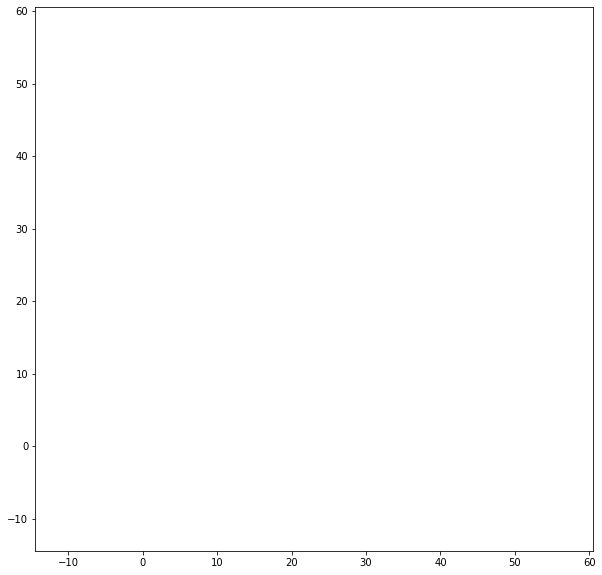

In [3]:
from functools import partial
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from captum.attr import IntegratedGradients
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from torch import float32, nn, optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib
import copy
class MLP(nn.Module):
    # def __init__(self):
    def __init__(self, units=100 ,l1=120, l2=84):
        super().__init__()
        self.lin1 = nn.Linear(11, units)
        self.lin2 = nn.Linear(units, 1)

    def forward(self, xb):
        xb = F.relu(self.lin1(xb))
        xb = self.lin2(xb)
        return xb
marks = ['H2A.Z', 'H3K27ac', 'H3K79me2', 'H3K27me3',
                                 'H3K9ac', 'H3K4me2', 'H3K4me3', 'H3K9me3',
                                 'H3K4me1', 'H3K36me3', 'H4K20me1']
df = pd.read_csv(
    '../data/K562_2000_merged_histones_init.csv.gz', compression='gzip')
masks = pd.read_csv('../data/hg19_2000_no_N_inside.csv')
print('Number of NANs is {}'.format(masks['signal'].sum()))
df.loc[~masks['signal'].astype(bool)] = np.nan
df = df.dropna()
print(df)
# for i in marks + ['initiation']:
#     df[i] = df[i] + np.min(df[i][(df[i] != 0)])
#     df[i] = np.log10(df[i])
df1 = copy.deepcopy(df)
for i in marks + ['initiation']:
    df[i] = (df[i] - np.min(df[i])) / (np.max(df[i]) - np.min(df[i]))
X = df.loc[:, marks].to_numpy()
X_train = df.loc[df['chrom'] != 'chr1', marks].to_numpy()
print(X_train.shape)
y_train = df.loc[df['chrom'] != 'chr1', ['initiation']].to_numpy()
print(y_train.shape)
X_test = df.loc[df['chrom'] == 'chr1', marks].to_numpy()
y_test = df.loc[df['chrom'] == 'chr1', ['initiation']].to_numpy()
print(X)
X_train = torch.tensor(X_train, dtype=float32)
y_train = torch.tensor(y_train, dtype=float32)
X_test = torch.tensor(X_test, dtype=float32)
X = torch.tensor(X, dtype=float32)
model = MLP()
model.load_state_dict(torch.load('../development/model_weights.pth'))
model.eval()
predicted = model(X_train)
predicted_test = model(X_test)
predicted1 = model(X)
predicted = predicted.detach().numpy() * (np.max(df1['initiation'].to_numpy()) - np.min(df1['initiation'].to_numpy())) + np.min(df1['initiation'].to_numpy())
predicted1 = predicted1.detach().numpy() *  (np.max(df1['initiation'].to_numpy()) - np.min(df1['initiation'].to_numpy())) + np.min(df1['initiation'].to_numpy())
predicted_test = predicted_test.detach().numpy() *  (np.max(df1['initiation'].to_numpy()) - np.min(df1['initiation'].to_numpy())) + np.min(df1['initiation'].to_numpy())
y_train = y_train.detach().numpy() *  (np.max(df1['initiation']) - np.min(df1['initiation'])) + np.min(df1['initiation'])
y_test = y_test *  (np.max(df1['initiation']) - np.min(df1['initiation'])) + np.min(df1['initiation'])
df['initiation'] = df['initiation'] *  (np.max(df1['initiation']) - np.min(df1['initiation'])) + np.min(df1['initiation'])

print(mean_squared_error(predicted, y_train))
print(mean_squared_error(predicted_test, y_test))
df['predicted'] = predicted1
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(df.index[df['chrom'] == 'chr1'] * 2000),
    y=list(df.loc[df['chrom'] == 'chr1', 'initiation']), name='PODLS'))
fig.add_trace(go.Scatter(x=list(df.index[df['chrom'] == 'chr1'] * 2000),
    y=list(df.loc[df['chrom'] == 'chr1', 'predicted']), name='Predictions from FCNN'))
fig.add_trace(go.Scatter(x=list(df.index[df['chrom'] == 'chr1'] * 2000), 
    y=list(np.abs(df.loc[df['chrom'] == 'chr1', 'predicted'].to_numpy()-df.loc[df['chrom'] == 'chr1',
        'initiation'].to_numpy())), name='Absolute error'))
fig.write_html("../development/profile.html")
plt.figure(figsize=(10, 10))
p1 = max(max(predicted), max(y_train))
p2 = min(min(predicted), min(y_train))
plt.plot([p1, p2], [p1, p2], 'w-')
plt.hist2d(np.log10(y_train + 1).ravel(), np.log10(predicted + 1).ravel(),
            bins=[100, 100],
            cmap=plt.cm.nipy_spectral, norm=matplotlib.colors.LogNorm(
                vmin=None, vmax=None, clip=False))
plt.colorbar()
plt.xlabel('Log(observed values+1)')
plt.ylabel('Log(predicted values+1)')
plt.title('Predicted values with respect to the observed values for K562')
plt.savefig('../development/2dhistogram.png',
            dpi=300, bbox_inches='tight', transparent=False)
